In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({
    "font.size": 16})
rcParams['axes.titlepad'] = 20

## Load in Data

In [16]:
from boutdata import collect
from boutdata.data import BoutData
import re
import os

job_ids = [re.search('(\d){7}', dir).group() for dir in os.listdir("./shared/NORTH/") if re.search('data_(\d){7}', dir)]
job_ids.sort()
job_id = job_ids[-1]
# job_id = '5672085'
print('job_id', job_id)
path = './shared/NORTH/data_' + job_id + '/'

job_id 5699565


In [17]:
bdata = BoutData(path)
outputs = bdata['outputs']
field_keys = outputs.keys()
options = bdata['options']

/home/niflheim/s173965/local/venv/north-simulation/lib64/python3.6/site-packages/boutdata/data.py:769: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  + "\nEvaluating non-scalar options not available"


In [18]:
def get_option(*keys):
    from numpy import sqrt, pi
    from ast import parse, walk, Name
    val = options
    group = keys[0]
    for key in keys:
        val = val[key]
    try:
        return eval(str(val))
    except:
        # Parse undefined variables from the Bout.inp file:
        val_str = str(val).replace(':', '____') # Replace group indicator ':' with '____' to make string parsable.
        for node in walk(parse(val_str)):
            if type(node) is Name:
                missing_keys = node.id.split('____')
                var = missing_keys[-1]
                if var not in locals():
                    try:
                        locals()[var] = get_option(*missing_keys)
                    except:
                        missing_keys.insert(0, group)
                        try:
                            locals()[var] = get_option(*missing_keys)
                        except:
                            print('Error reading option for keys: ', keys)
                            return 0
        return eval(str(val))

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

In [19]:
oci, rho_s, R, a, n0, n_n, E_ion, mxg, myg, nx_all, ny_all, nz_all = get_options([
    ('north', 'oci'), ('north', 'rho_s'), ('north', 'R'), ('north', 'a'), ('north', 'n0'), ('north', 'n_n'), ('north', 'E_ion'),
    ('mxg',), ('myg',),
    ('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
Lx = a/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

In [20]:
print('nx: ', options['mesh']['nx'])
print('ny: ', options['mesh']['ny'])
print('nz: ', options['mesh']['nz'])
print('Lx: ', options['mesh']['Lx'])
print('rho_s: ', options['north']['rho_s'])
print('oci: ', options['north']['oci'])

nx:  48+2*mxg
ny:  1
nz:  128
Lx:  north:a/north:rho_s
rho_s:  c_s/oci
oci:  e*B0/(mi)


In [22]:
#%% Read data

field_list  = ['T', 'n', 'phi', 'vort', 'source_T','wall_shadow']
par_list    = ['t_array']
# fast_list   = ['t_array', 'n0', 'phi0', 'n1', 'phi1', 'n2', 'phi2', 'T0', 'T1', 'T2']
#%%
data, par, fast = {}, {}, {}

for _field in field_list:
    data[_field] = collect(_field, path = path, xguards = False)

for _par in par_list:
    par[_par] = collect(_par, path = path, xguards = False)

mxsub = 2 mysub = 1 mz = 128

nxpe = 24, nype = 1, npes = 24

Reading from 0: [2-3][0-0] -> [0-1][0-0]

Reading from 1: [2-3][0-0] -> [2-3][0-0]

Reading from 2: [2-3][0-0] -> [4-5][0-0]

Reading from 3: [2-3][0-0] -> [6-7][0-0]

Reading from 4: [2-3][0-0] -> [8-9][0-0]

Reading from 5: [2-3][0-0] -> [10-11][0-0]

Reading from 6: [2-3][0-0] -> [12-13][0-0]

Reading from 7: [2-3][0-0] -> [14-15][0-0]

Reading from 8: [2-3][0-0] -> [16-17][0-0]

Reading from 9: [2-3][0-0] -> [18-19][0-0]

Reading from 10: [2-3][0-0] -> [20-21][0-0]

Reading from 11: [2-3][0-0] -> [22-23][0-0]

Reading from 12: [2-3][0-0] -> [24-25][0-0]

Reading from 13: [2-3][0-0] -> [26-27][0-0]

Reading from 14: [2-3][0-0] -> [28-29][0-0]

Reading from 15: [2-3][0-0] -> [30-31][0-0]

Reading from 16: [2-3][0-0] -> [32-33][0-0]

Reading from 17: [2-3][0-0] -> [34-35][0-0]

Reading from 18: [2-3][0-0] -> [36-37][0-0]

Reading from 19: [2-3][0-0] -> [38-39][0-0]

Reading from 20: [2-3][0-0] -> [40-41][0-0]

Reading from 

In [23]:
thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(Lx/(2*nx_inner), Lx+Lx/(2*nx_inner), nx_inner)
t = par['t_array']/oci

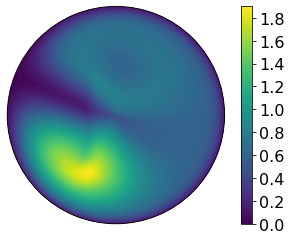

In [24]:
dmp_nr = 20

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_rticks([])
ax.set_xticks([])
cont = ax.contourf(thetas, rhos, data['n'].squeeze()[dmp_nr, :, :], 100)    # first image on screen
fig.colorbar(cont, ax=ax)

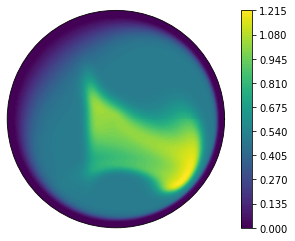

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_rticks([])
ax.set_xticks([])
cont = ax.contourf(thetas, rhos, data['T'].squeeze()[dmp_nr, :, :], 100)    # first image on screen
fig.colorbar(cont, ax=ax)

In [25]:
mesh_t, mesh_rhos, mesh_thetas = np.meshgrid(t, rhos, thetas, indexing='ij')
mesh_t.shape, mesh_rhos.shape, mesh_thetas.shape

((40, 48, 128), (40, 48, 128), (40, 48, 128))

In [26]:
Jfun = lambda t, r, theta: np.abs(r*(R + r*np.cos(theta)))

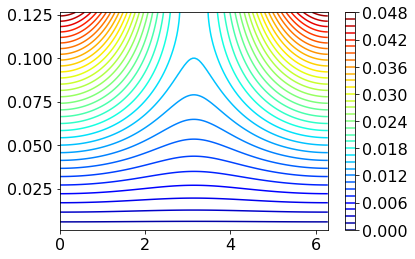

In [27]:
plt.contour(thetas, rhos, Jfun(mesh_t, mesh_rhos, mesh_thetas)[0, :, :], 40, cmap='jet')
plt.colorbar()

In [28]:
volume = 2*np.pi*np.trapz(np.trapz(Jfun(mesh_t, mesh_rhos, mesh_thetas)[0,:,:], rhos, axis=0), thetas, axis=0)
print('test of Jacobian. Volume of torus is: ' + str(volume) + ' m^3')

test of Jacobian. Volume of torus is: 0.07871266530816706 m^3


In [ ]:
def energy():
    n = data['n'].squeeze()*n0
    T = data['T'].squeeze()*Te0
    J = Jfun(mesh_t, mesh_rhos, mesh_thetas)
    return 2*np.pi*np.trapz(np.trapz(J*((3/2)*n*T), rhos, axis=1), thetas, axis=1)

E = energy()

In [ ]:
rcParams.update({
    "font.size": 16})
rcParams['axes.titlepad'] = 20

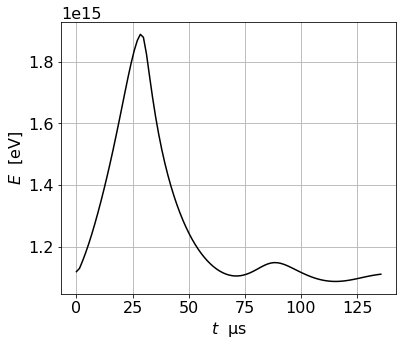

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(t*(10**6), E, 'k-')
plt.xlabel(r'$t$  $\mathrm{\mu s}$')
plt.ylabel(r'$E$  $\mathrm{[eV]}$')
plt.grid()
plt.savefig('plots/' + job_id + 'energy.pdf')